In [100]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg
from sympy import *

import time
import numpy as np
from sympy import symbols
from sympy import *
import matplotlib.pyplot as plt
import ae353_cmg

#Defining System
J1z = 0.5
J2x = .001
J2z = .001
J3x = .01
J3y = .01
J3z = .01
m = 1
r = 2
g = 9.81
vrotor = 500

a1 = -J3y + 2*J3z
a2 = 2*J3y
a3 = -2*g*m*r
a4 = 2*J1z+2*J2z+2*m*r**2
a5 = 2*J3z
a6 = (J3y-J3z)/(2*(J2x+J3x))
a7 = -J3y/(J2x+J3x)
a8 = 1/(J2x+J3x)

q1,q2,q1dot,q2dot,tau = symbols('q1,q2,q1dot,q2dot,tau')

q1dotdot = (a1*sin(2*q2)*q1dot*q2dot+a2*cos(q2)*q2dot*vrotor+a3*sin(q1))/(a4+a5*cos(q2)**2)
q2dotdot = a6*sin(2*q2)*q1dot**2+a7*cos(q2)*q1dot*vrotor+a8*tau

#Convert to First Order ODE
w = Matrix([[q1],
             [q1dot],
             [q2],
             [q2dot]])
p = Matrix([tau])

f = Matrix([[q1dot],
                [q1dotdot],
                [q2dot],
                [q2dotdot]])

#Equilibrium Point
w0 = Matrix([[0],
              [0],
              [0],
              [0]])
p0 = Matrix([0])

#Solving for State-Space Form
A_sym = f.jacobian(w)
A = A_sym.subs([(q1,w0[0]),(q1dot,w0[1]),(q2,w0[2]),(q2dot,w0[3]),(tau,p0[0])])
B_sym = f.jacobian(p)
B = B_sym.subs([(q1,w0[0]),(q1dot,w0[1]),(q2,w0[2]),(q2dot,w0[3]),(tau,p0[0])])
#Designing a Linear Feedback Controller
# where u = -K*x
p = Matrix([[-.1, -2, -30, -400]])

x,t = symbols('x,t')

desiredPoly = 1

for h in p:
    desiredPoly = desiredPoly*(x-h)
desiredPoly = desiredPoly.expand()
desiredPoly = Poly(desiredPoly, x)
alpha = Matrix(desiredPoly.coeffs())
alpha.row_del(0)
alpha = alpha.transpose()

charA = A.charpoly(x)
beta = Matrix(charA.all_coeffs())
beta.row_del(0)
beta = beta.transpose()

Accf = eye(shape(beta)[1])
Accf.row_del(shape(beta)[1]-1)
Accf = Accf.row_insert(0, -beta)

Bccf = zeros(shape(Accf)[1]-1, 1)
Bccf = Bccf.row_insert(0, Matrix([1]))

W = Matrix([[]])
for i in range(shape(A)[0]):
    C = A**i*B
    W = W.col_insert(i,C)

Wccf = Matrix([[]])
for i in range(shape(Accf)[0]):
    C = Accf**i*Bccf
    Wccf = Wccf.col_insert(i,C)

L = alpha-beta

K = L*Wccf*W**-1

simulator = ae353_cmg.Simulator(
    display=True,
    damping=0.,
    load_mass=1.,
    roll=(np.pi / 2),
)

simulator.camera_sideview()

class Controller:
    def __init__(self):
        pass
    
    def reset(self):
        pass
    
    def run(
            self,
            t,
            platform_angle,
            platform_velocity,
            gimbal_angle,
            gimbal_velocity,
        ):
        
        # FIXME: replace the following line
        w1 = Matrix([[platform_angle],
                   [platform_velocity],
                   [gimbal_angle],
                   [gimbal_velocity]])
        x = w1-w0
        tau = (-K*(x))[0]
        
        
        if(tau <= 1 and tau >= -1):
            gimbal_torque = tau
        elif(tau < -1):
            gimbal_torque = -1
        else:
            gimbal_torque = 1
        
        
        #gimbal_torque = tau
        
        return gimbal_torque

controller = Controller()

simulator.reset(
    platform_angle=-.95,
    platform_velocity=0,
    gimbal_angle=0.,
    gimbal_velocity=0.,
    rotor_velocity=500.,
)

controller.reset()

data = simulator.run(
    controller,           # <-- required (an instance of your Controller class)
    max_time=30.0,         # <-- optional (how long you want to run the simulation in seconds)
    data_filename=None,   # <-- optional (name of file to which you want data saved, e.g., 'my_data.json')
    video_filename=None,  # <-- optional (name of file to which you want video saved, e.g., 'my_video.mov')
)

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7022/static/


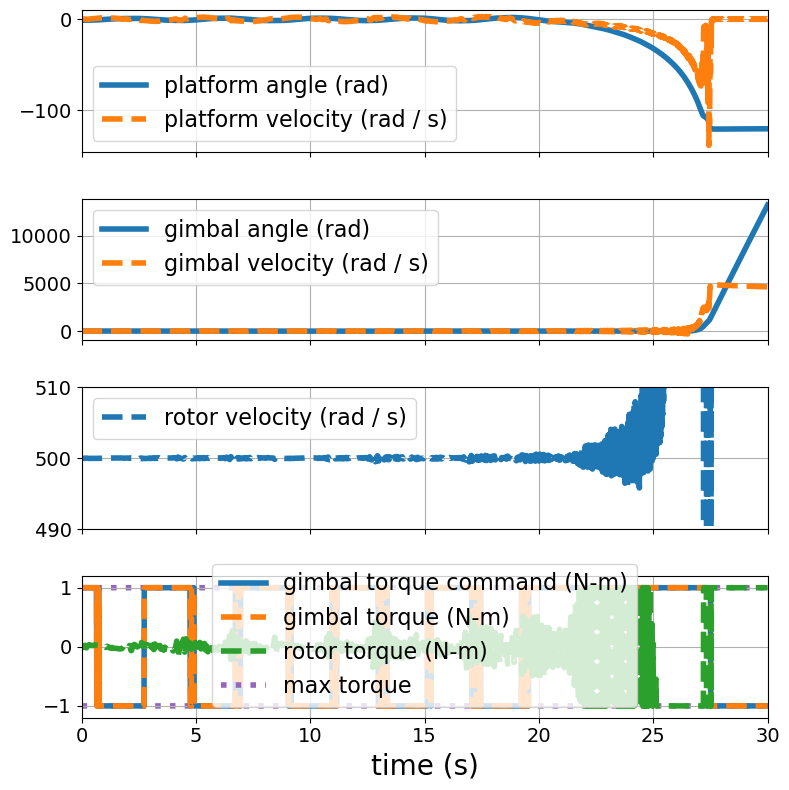

In [101]:
# Create a figure with three subplots, all of which share the same x-axis
fig, (ax_platform, ax_gimbal, ax_rotor, ax_torque) = plt.subplots(4, 1, figsize=(8, 8), sharex=True)

# Plot platform angle and velocity
ax_platform.plot(
    data['t'], data['platform_angle'],
    label='platform angle (rad)', linewidth=4,
)
ax_platform.plot(
    data['t'], data['platform_velocity'],
    '--', label='platform velocity (rad / s)', linewidth=4,
)
ax_platform.grid()
ax_platform.legend(fontsize=16)
ax_platform.tick_params(labelsize=14)

# Plot gimbal angle and velocity
ax_gimbal.plot(
    data['t'], data['gimbal_angle'],
    label='gimbal angle (rad)', linewidth=4,
)
ax_gimbal.plot(
    data['t'], data['gimbal_velocity'],
    '--', label='gimbal velocity (rad / s)', linewidth=4,
)
ax_gimbal.grid()
ax_gimbal.legend(fontsize=16)
ax_gimbal.tick_params(labelsize=14)

# Plot rotor velocity
ax_rotor.plot(
    data['t'], data['rotor_velocity'],
    '--', label='rotor velocity (rad / s)', linewidth=4,
)
ax_rotor.grid()
ax_rotor.legend(fontsize=16)
ax_rotor.tick_params(labelsize=14)
ax_rotor.set_ylim(simulator.rotor_velocity - 10., simulator.rotor_velocity + 10.)

# Plot torques
ax_torque.plot(
    data['t'], data['gimbal_torque_command'],
    label='gimbal torque command (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['gimbal_torque'],
    '--', label='gimbal torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], data['rotor_torque'],
    '--', label='rotor torque (N-m)', linewidth=4,
)
ax_torque.plot(
    data['t'], np.ones_like(data['t']) * simulator.tau_max,
    ':', label='max torque', linewidth=4, color='C4', zorder=0,
)
ax_torque.plot(
    data['t'], -np.ones_like(data['t']) * simulator.tau_max,
    ':', linewidth=4, color='C4', zorder=0,
)
ax_torque.grid()
ax_torque.legend(fontsize=16)
ax_torque.tick_params(labelsize=14)

# Set x-axis properties (only need to do this on the last
# subplot since all subplots share the same x-axis)
ax_torque.set_xlabel('time (s)', fontsize=20)
ax_torque.set_xlim([data['t'][0], data['t'][-1]])
ax_torque.set_ylim(-1.2 * simulator.tau_max, 1.2 * simulator.tau_max)

# Make the arrangement of subplots look nice
fig.tight_layout()

In [102]:
fig.savefig('my_figure.png', facecolor='white', transparent=False)

Matrix([[232., 118., 6.07, 4.75]])


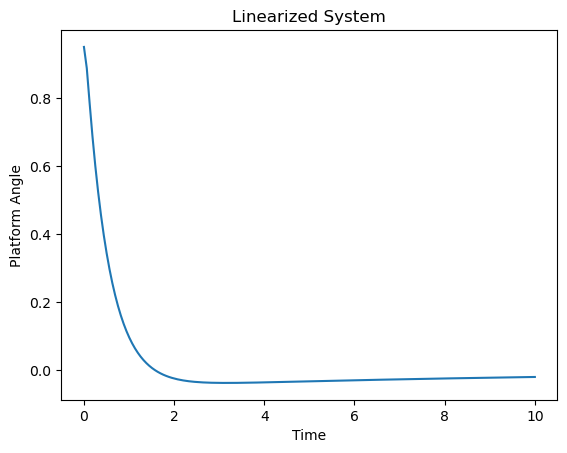

In [99]:
# This module is part of the python standard library
import time

# These modules are part of other existing libraries
import numpy as np
import matplotlib.pyplot as plt

# This is my own script (it is an interface to the pybullet simulator)
import ae353_cmg
from sympy import *

import time
import numpy as np
from sympy import symbols
from sympy import *
import matplotlib.pyplot as plt
import ae353_cmg
import control
from scipy.linalg import expm

#Defining System
J1z = 0.5
J2x = .001
J2z = .001
J3x = .01
J3y = .01
J3z = .01
m = 1
r = 2
g = 9.81
vrotor = 500

a1 = -J3y + 2*J3z
a2 = 2*J3y
a3 = -2*g*m*r
a4 = 2*J1z+2*J2z+2*m*r**2
a5 = 2*J3z
a6 = (J3y-J3z)/(2*(J2x+J3x))
a7 = -J3y/(J2x+J3x)
a8 = 1/(J2x+J3x)

q1,q2,q1dot,q2dot,tau = symbols('q1,q2,q1dot,q2dot,tau')

q1dotdot = (a1*sin(2*q2)*q1dot*q2dot+a2*cos(q2)*q2dot*vrotor+a3*sin(q1))/(a4+a5*cos(q2)**2)
q2dotdot = a6*sin(2*q2)*q1dot**2+a7*cos(q2)*q1dot*vrotor+a8*tau

#Convert to First Order ODE
w = Matrix([[q1],
             [q1dot],
             [q2],
             [q2dot]])
p = Matrix([tau])

f = Matrix([[q1dot],
                [q1dotdot],
                [q2dot],
                [q2dotdot]])

#Equilibrium Point
w0 = Matrix([[0],
              [0],
              [0],
              [0]])
p0 = Matrix([0])

#Solving for State-Space Form
A_sym = f.jacobian(w)
A = A_sym.subs([(q1,w0[0]),(q1dot,w0[1]),(q2,w0[2]),(q2dot,w0[3]),(tau,p0[0])])
B_sym = f.jacobian(p)
B = B_sym.subs([(q1,w0[0]),(q1dot,w0[1]),(q2,w0[2]),(q2dot,w0[3]),(tau,p0[0])])

#Designing a Linear Feedback Controller
# where u = -K*x
p = Matrix([[-.1, -2, -30, -400]])

x,t = symbols('x,t')

desiredPoly = 1

for h in p:
    desiredPoly = desiredPoly*(x-h)
desiredPoly = desiredPoly.expand()
desiredPoly = Poly(desiredPoly, x)
alpha = Matrix(desiredPoly.coeffs())
alpha.row_del(0)
alpha = alpha.transpose()

charA = A.charpoly(x)
beta = Matrix(charA.all_coeffs())
beta.row_del(0)
beta = beta.transpose()

Accf = eye(shape(beta)[1])
Accf.row_del(shape(beta)[1]-1)
Accf = Accf.row_insert(0, -beta)

Bccf = zeros(shape(Accf)[1]-1, 1)
Bccf = Bccf.row_insert(0, Matrix([1]))

W = Matrix([[]])
for i in range(shape(A)[0]):
    C = A**i*B
    W = W.col_insert(i,C)

Wccf = Matrix([[]])
for i in range(shape(Accf)[0]):
    C = Accf**i*Bccf
    Wccf = Wccf.col_insert(i,C)

L = alpha-beta

K = L*Wccf*W**-1
print(K.evalf(3))

#Applying Linear Feedback Controller to Linearized System
M = (A-B*K)
x0 = Matrix([[0.95],
              [0],
              [0],
              [0]])
t_r = np.linspace(0,10,160)
x_t = Matrix([])
for i in range(shape(t_r)[0]):
    x_t = x_t.col_insert(i,(expm(M*t_r[i])*x0))

#Graphing Linear System
plt.plot(t_r,x_t.row(0).T)
plt.xlabel('Time')
plt.ylabel('Platform Angle')
plt.title('Linearized System')
plt.show()